# Importações

In [4]:
import os
import shutil
import random
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import time
import torch

# Instalar YOLOV5

In [1]:
!git clone https://github.com/ArtBreguez/yolov5
%cd yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.
/tmp/tcc_alpd/yolov5/yolov5


/home/alertrack/anaconda3/envs/yolo/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [37]:
!pip install -r requirements.txt

In [31]:
import utils
display = utils.notebook_init()

YOLOv5 🚀 254aef3 Python-3.9.19 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12035MiB)


Setup complete ✅ (6 CPUs, 15.6 GB RAM, 145.2/914.8 GB disk)


# Preparar Dataset

In [7]:
!curl -L -o /tmp/tcc_alpd/archive.tar.gz "https://www.dropbox.com/scl/fi/khnnv0x8pcpbzlgfevqac/archive.tar.gz?rlkey=55w3pkxp02szjpqw22df7hmn8&dl=0"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    237      0 --:--:--  0:00:01 --:--:--   237
100   491    0   491    0     0    207      0 --:--:--  0:00:02 --:--:--   600
100  202M  100  202M    0     0  12.7M      0  0:00:15  0:00:15 --:--:-- 16.2M


In [8]:
!tar xfv /tmp/tcc_alpd/archive.tar.gz -C /tmp/tcc_alpd

archive/
archive/.DS_Store
archive/images/
archive/annotations/
archive/annotations/Cars213.xml
archive/annotations/Cars207.xml
archive/annotations/Cars398.xml
archive/annotations/Cars367.xml
archive/annotations/Cars401.xml
archive/annotations/Cars415.xml
archive/annotations/Cars373.xml
archive/annotations/Cars429.xml
archive/annotations/Cars47.xml
archive/annotations/Cars53.xml
archive/annotations/Cars165.xml
archive/annotations/Cars171.xml
archive/annotations/Cars159.xml
archive/annotations/Cars84.xml
archive/annotations/Cars90.xml
archive/annotations/Cars91.xml
archive/annotations/Cars85.xml
archive/annotations/Cars158.xml
archive/annotations/Cars170.xml
archive/annotations/Cars164.xml
archive/annotations/Cars52.xml
archive/annotations/Cars46.xml
archive/annotations/Cars428.xml
archive/annotations/Cars414.xml
archive/annotations/Cars372.xml
archive/annotations/Cars366.xml
archive/annotations/Cars400.xml
archive/annotations/Cars399.xml
archive/annotations/Cars206.xml
archive/annotati

In [4]:
IMAGE_PATH = "/tmp/tcc_alpd/archive/images"
ANNOTATIONS_PATH = "/tmp/tcc_alpd/archive/annotations"

DATASET_PATH = "Dataset/"
TRAIN_LABELS_PATH = "train/labels"
VAL_LABELS_PATH = "val/labels"
TRAIN_IMAGES_PATH = DATASET_PATH+"train/images"
VAL_IMAGES_PATH = DATASET_PATH+"val/images"

In [5]:
def split_dataset(source_dir, train_dir, val_dir, val_percentage=0.2):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(train_dir+"/labels", exist_ok=True)
    os.makedirs(val_dir+"/labels", exist_ok=True)
    os.makedirs(train_dir+"/images", exist_ok=True)
    os.makedirs(val_dir+"/images", exist_ok=True)

    files = os.listdir(source_dir)
    random.shuffle(files)

    num_val_files = int(len(files) * val_percentage)

    for i, file in enumerate(files):
        source_file = os.path.join(source_dir, file)
        if i < num_val_files:
            shutil.copy(source_file, os.path.join(val_dir, file))
        else:
            shutil.copy(source_file, os.path.join(train_dir, file))

In [6]:
split_dataset(IMAGE_PATH, DATASET_PATH+"train", DATASET_PATH+"val")

# Convertendo Labels para o formato YOLOV5


In [7]:
def convert_coordinates(size, box):
    x1, y1, x2, y2 = map(int, box)
    dw = np.float32(1.0 / int(size[0]))
    dh = np.float32(1.0 / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x_center = x1 + (w / 2)
    y_center = y1 + (h / 2)

    x_center *= dw
    w *= dw
    y_center *= dh
    h *= dh
    return [x_center, y_center, w, h]

def save_annotations(img_jpg_file_name, size, img_boxes, labels_path):
    classes = ['license']
    save_file_name = f"{DATASET_PATH}/{labels_path}/{img_jpg_file_name}.txt"
    
    with open(save_file_name, "a+") as file_path:
        for box in img_boxes:
            cls_num = 0
            new_box = convert_coordinates(size, box[1:])
            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

def parse_xml(file_path, img_xml_file, labels_path):
    img_path = f"{file_path}/{img_xml_file}.xml"
    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    img_boxes = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        img_jpg_file_name = f"{img_xml_file}.jpg"
        img_boxes.append([cls_name, x1, y1, x2, y2])
    save_annotations(img_xml_file, [img_w, img_h], img_boxes, labels_path)

def process_files(annotations_path, train_val_dir, labels_path, images_path):
    xml_files = [f for f in os.listdir(annotations_path) if f.endswith('.xml')]
    files = [f.split('.')[0] for f in os.listdir(train_val_dir) if f.endswith('.png')]
    
    for xml_file in xml_files:
        xml_name = xml_file.split('.')[0]
        if xml_name in files:
            parse_xml(annotations_path, xml_name, labels_path)
            src_path = os.path.join(train_val_dir, f"{xml_name}.png")
            dest_path = os.path.join(images_path, f"{xml_name}.png")
            shutil.move(src_path, dest_path)

In [8]:
process_files(ANNOTATIONS_PATH, DATASET_PATH+"train", TRAIN_LABELS_PATH, TRAIN_IMAGES_PATH)
process_files(ANNOTATIONS_PATH, DATASET_PATH+"val", VAL_LABELS_PATH, VAL_IMAGES_PATH)

# YOLOV5 treinamento


In [9]:
!python train.py --img 244 --batch 16 --epochs 50 --data data/alpr.yaml --cfg models/yolov5s.yaml

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/alpr.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=244, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ArtBreguez/yolov5 ✅
YOLOv5 🚀 254aef3 Python-3.9.19 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12035MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.01

# Analise de resultados

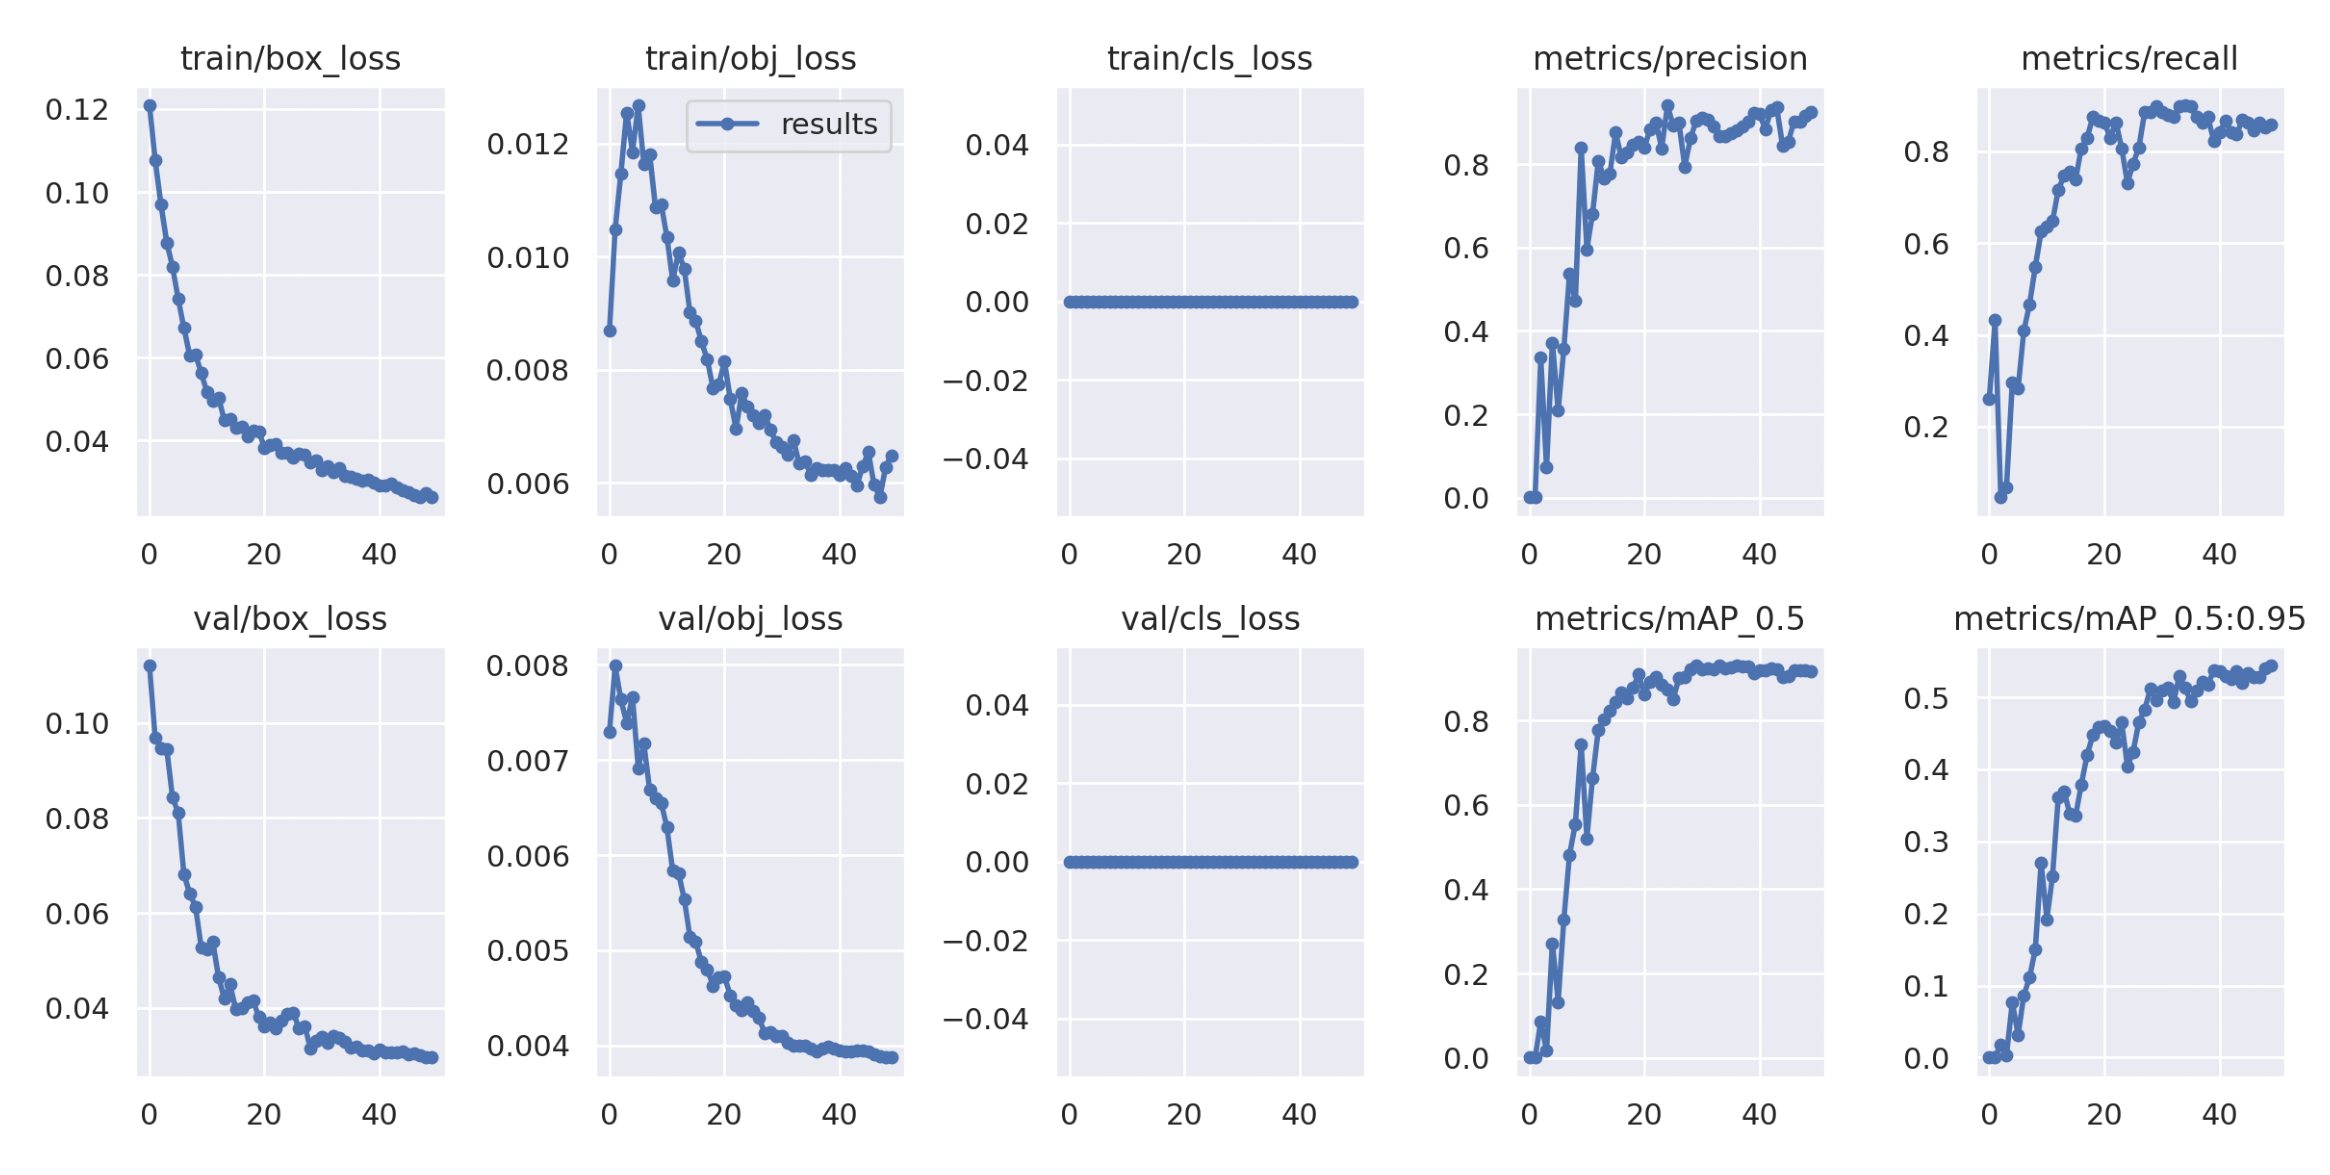

In [10]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/results.png'))

In [11]:
# validação
!python val.py --weights 'runs/train/exp/weights/best.pt' --img 244 --batch 64 --data data/alpr.yaml --project 'alpr' --name 'validation_on_test_data' --augment

val: data=data/alpr.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=64, imgsz=244, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=alpr, name=validation_on_test_data, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 254aef3 Python-3.9.19 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12035MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/tmp/tcc_alpd/yolov5/yolov5/Dataset/val/labels.cache' images and 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         86         88      0.927       0.87       0.93      0.547
Speed: 0.1ms pre-process, 8.3ms inference, 1.7ms NMS per image at shape (64, 3, 256, 256)
Results saved to alpr/validation_on_test_data


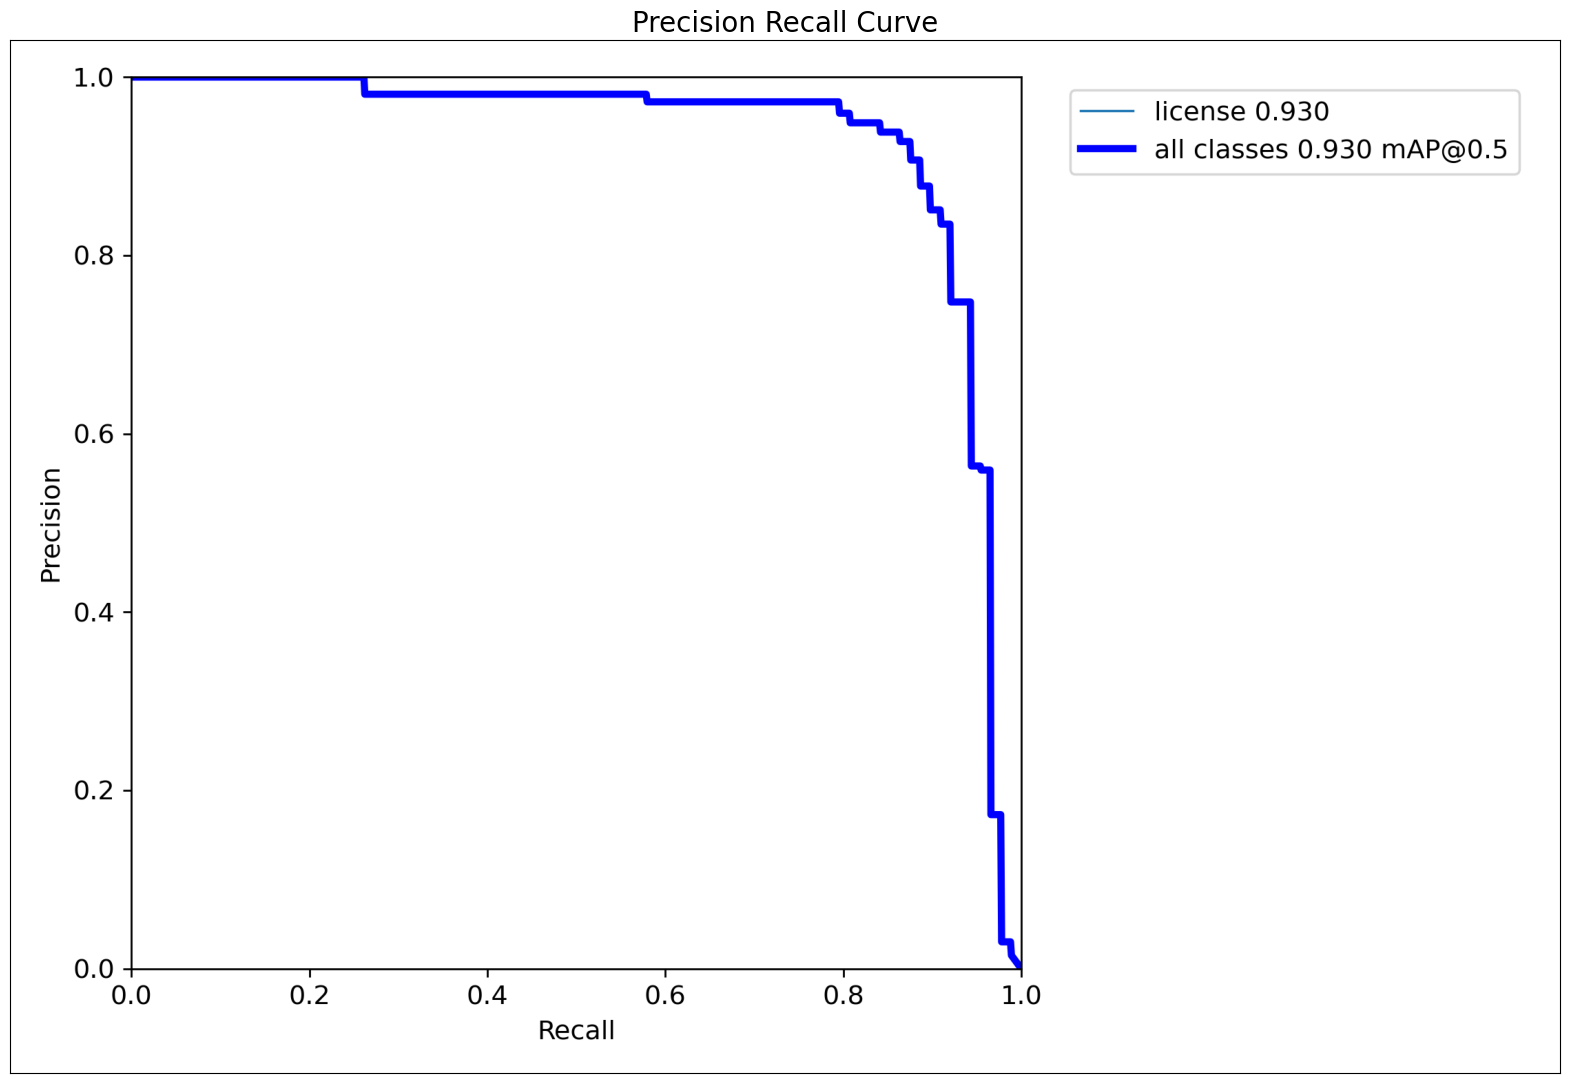

In [12]:
plt.figure(figsize=(20, 20))
imagem = mpimg.imread('alpr/validation_on_test_data/PR_curve.png')
plt.imshow(imagem, extent=[0, imagem.shape[1], 0, imagem.shape[0]])
plt.title('Precision Recall Curve', fontsize=20)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

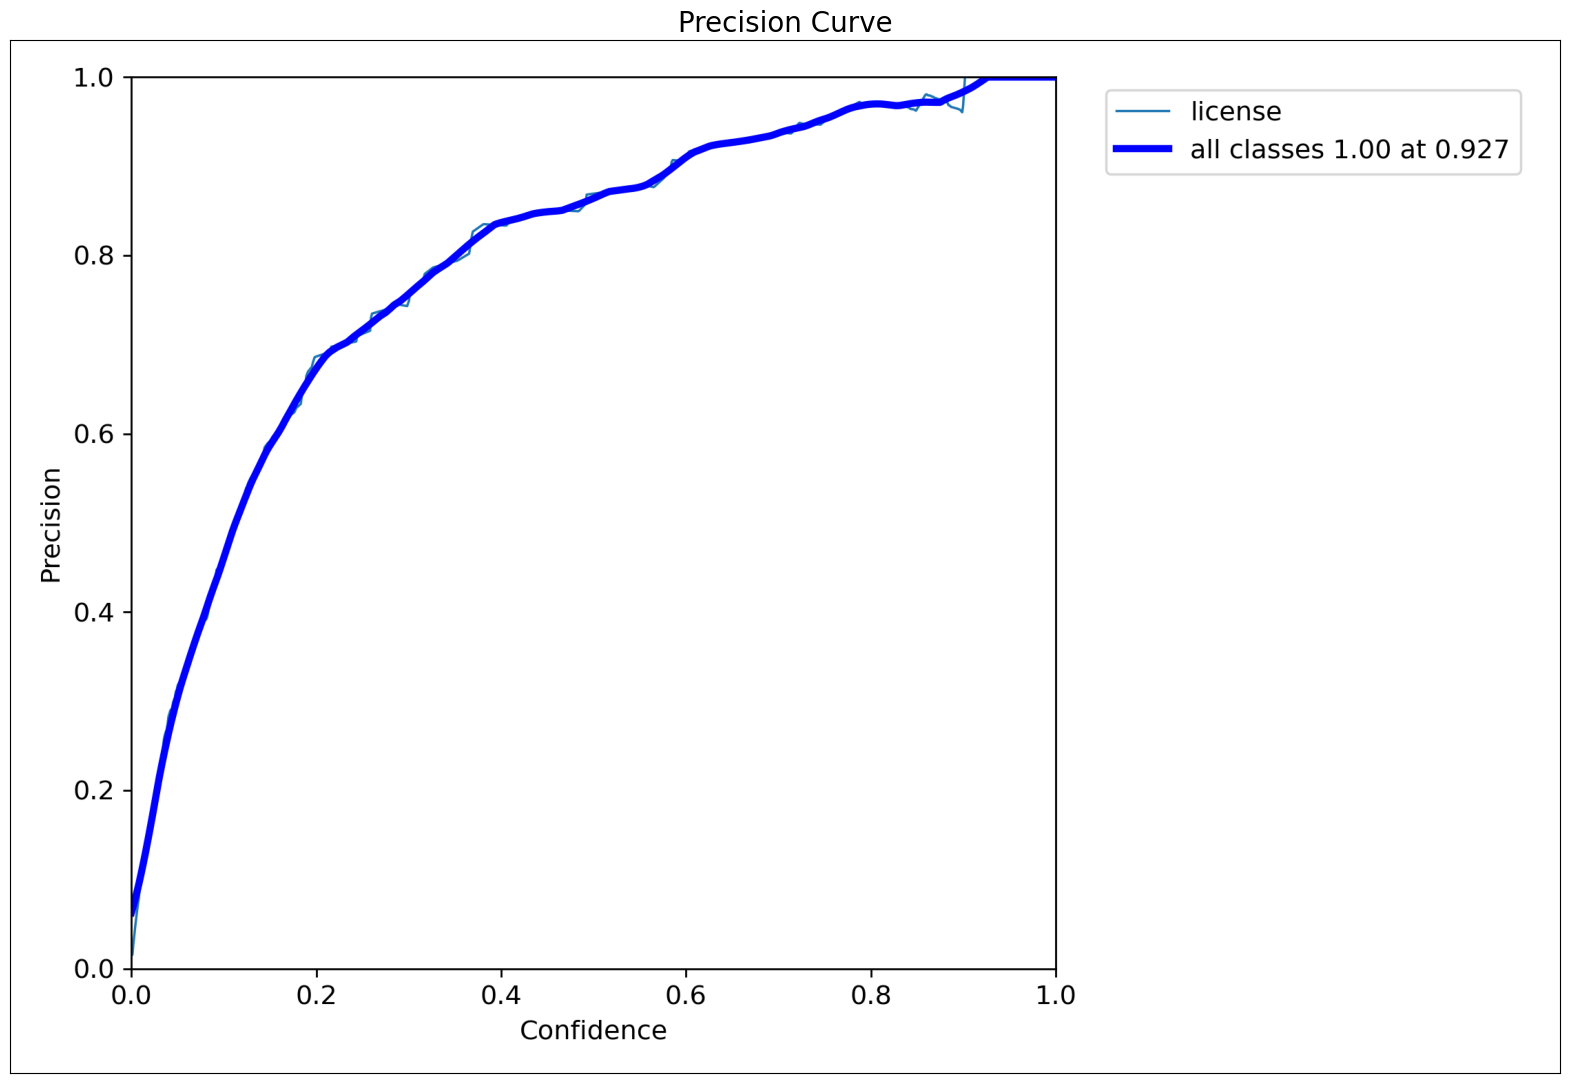

In [13]:
plt.figure(figsize=(20, 20))
imagem = mpimg.imread('alpr/validation_on_test_data/P_curve.png')
plt.imshow(imagem, extent=[0, imagem.shape[1], 0, imagem.shape[0]])
plt.title('Precision Curve', fontsize=20)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

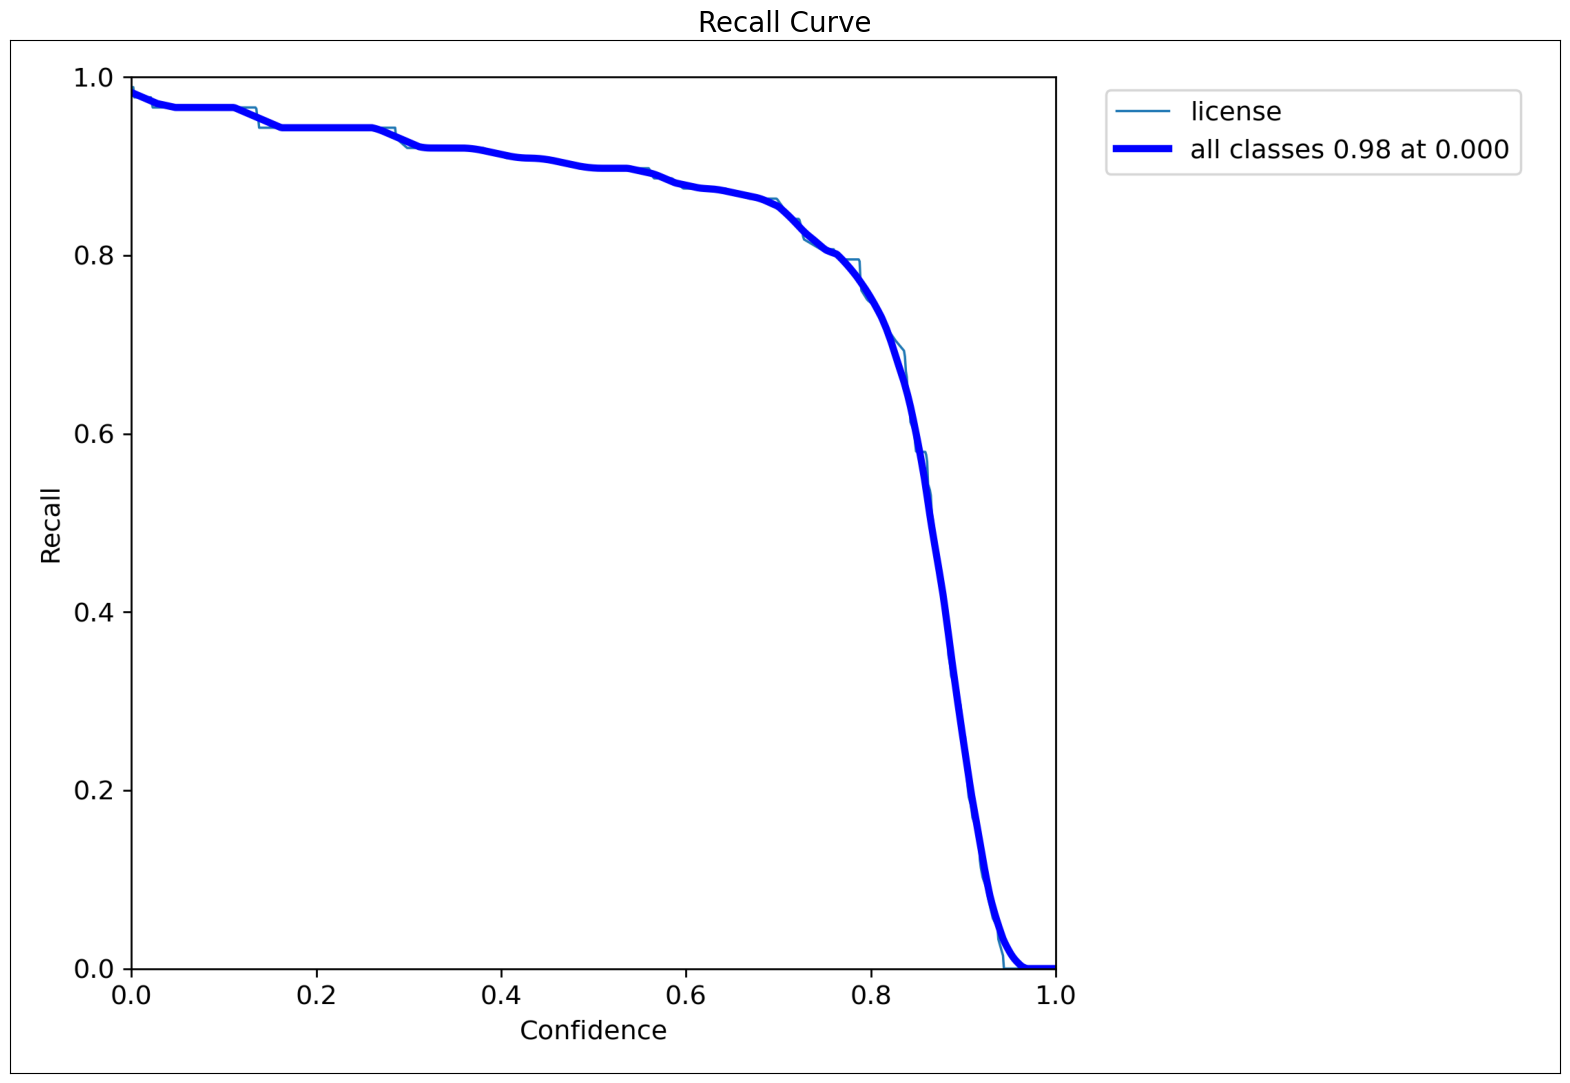

In [14]:
plt.figure(figsize=(20, 20))
imagem = mpimg.imread('alpr/validation_on_test_data/R_curve.png')
plt.imshow(imagem, extent=[0, imagem.shape[1], 0, imagem.shape[0]])
plt.title('Recall Curve', fontsize=20)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

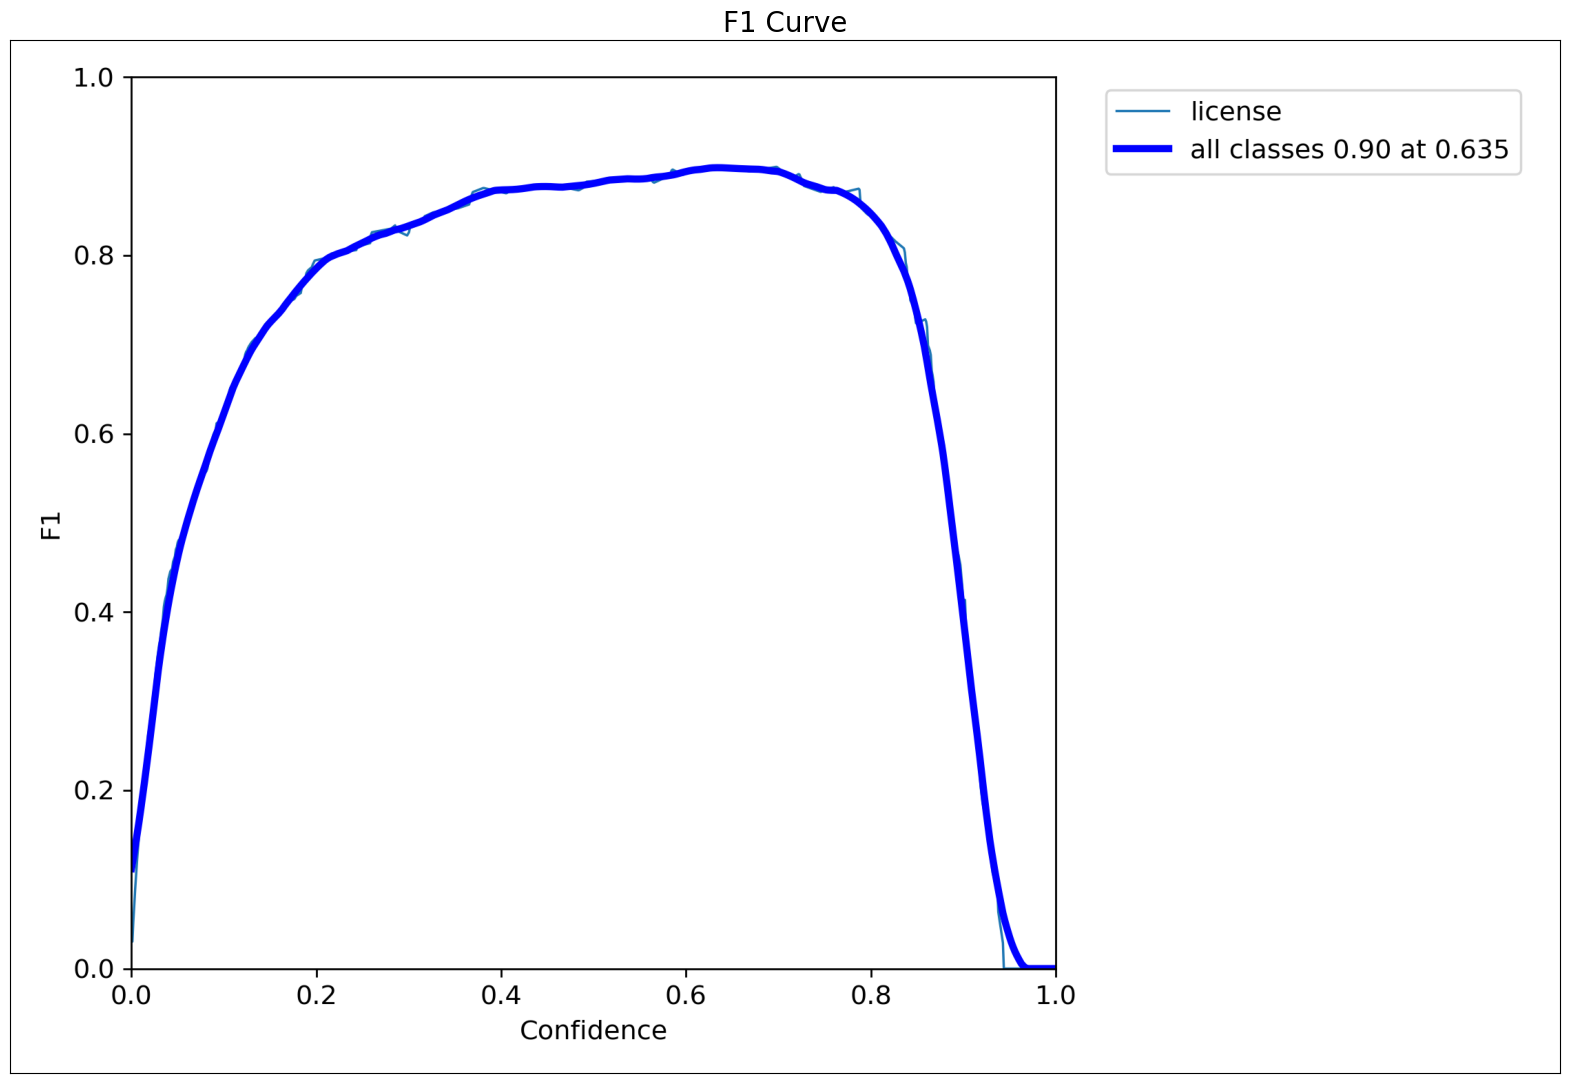

In [15]:
plt.figure(figsize=(20, 20))
imagem = mpimg.imread('alpr/validation_on_test_data/F1_curve.png')
plt.imshow(imagem, extent=[0, imagem.shape[1], 0, imagem.shape[0]])
plt.title('F1 Curve', fontsize=20)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

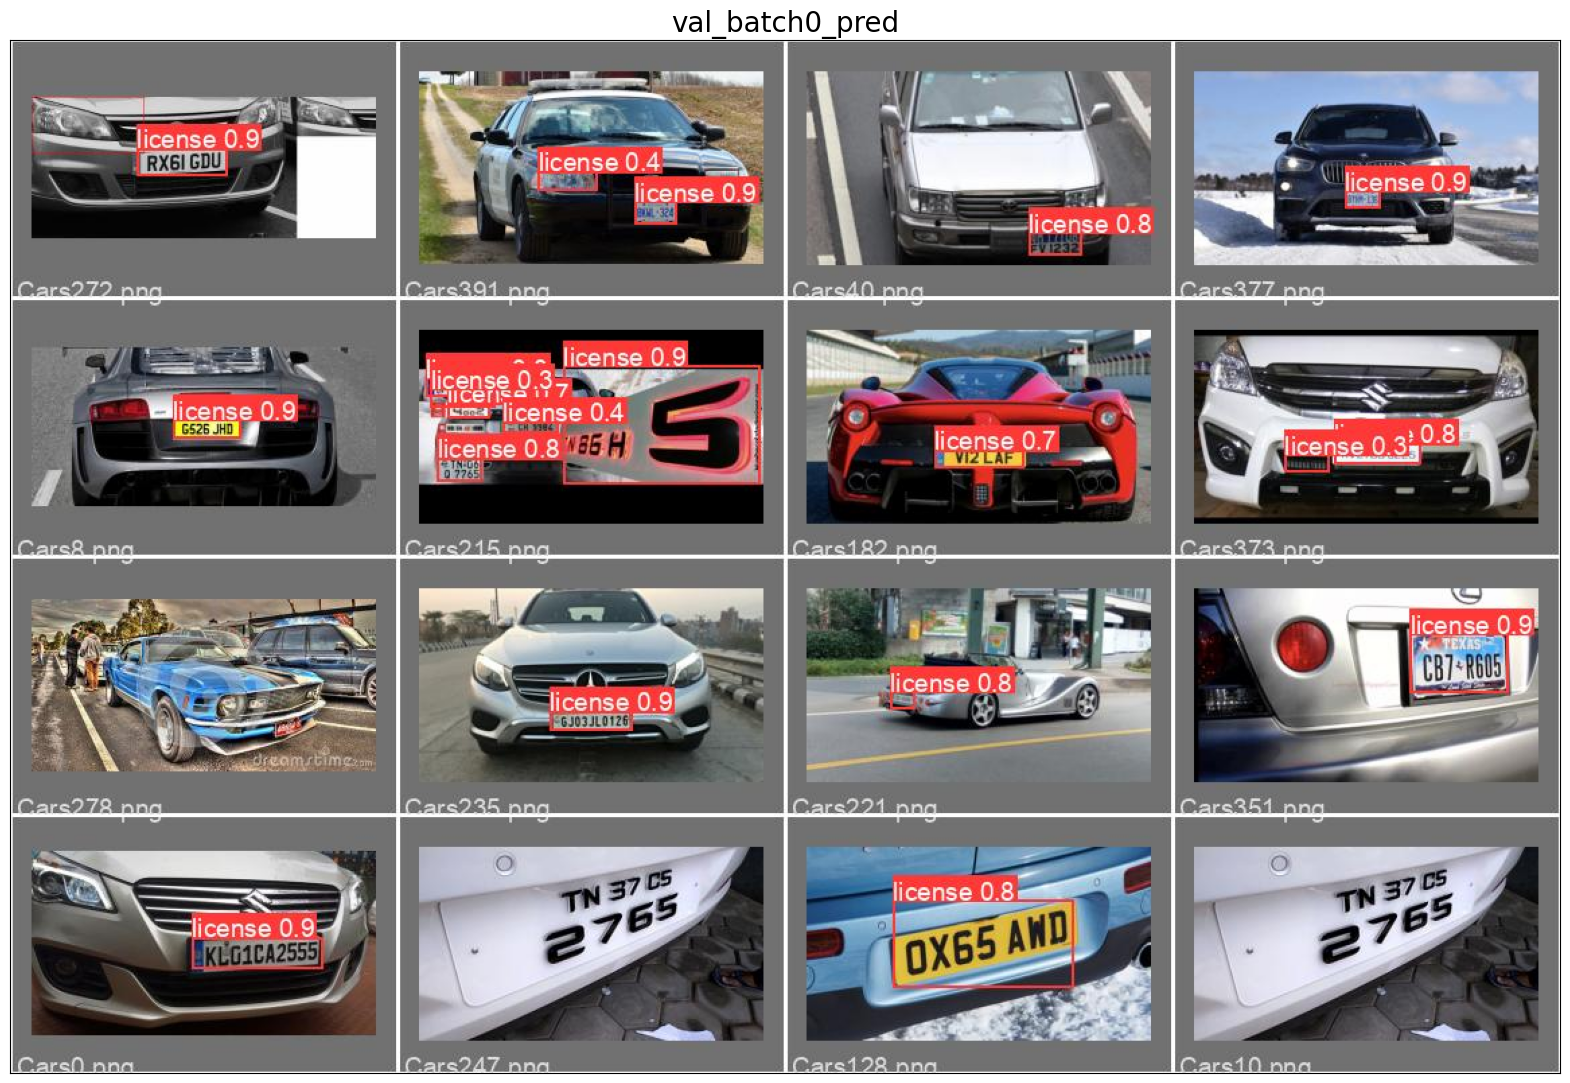

In [16]:
plt.figure(figsize=(20, 20))
imagem = mpimg.imread('runs/train/exp/val_batch0_pred.jpg')
plt.imshow(imagem, extent=[0, imagem.shape[1], 0, imagem.shape[0]])
plt.title('val_batch0_pred', fontsize=20)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

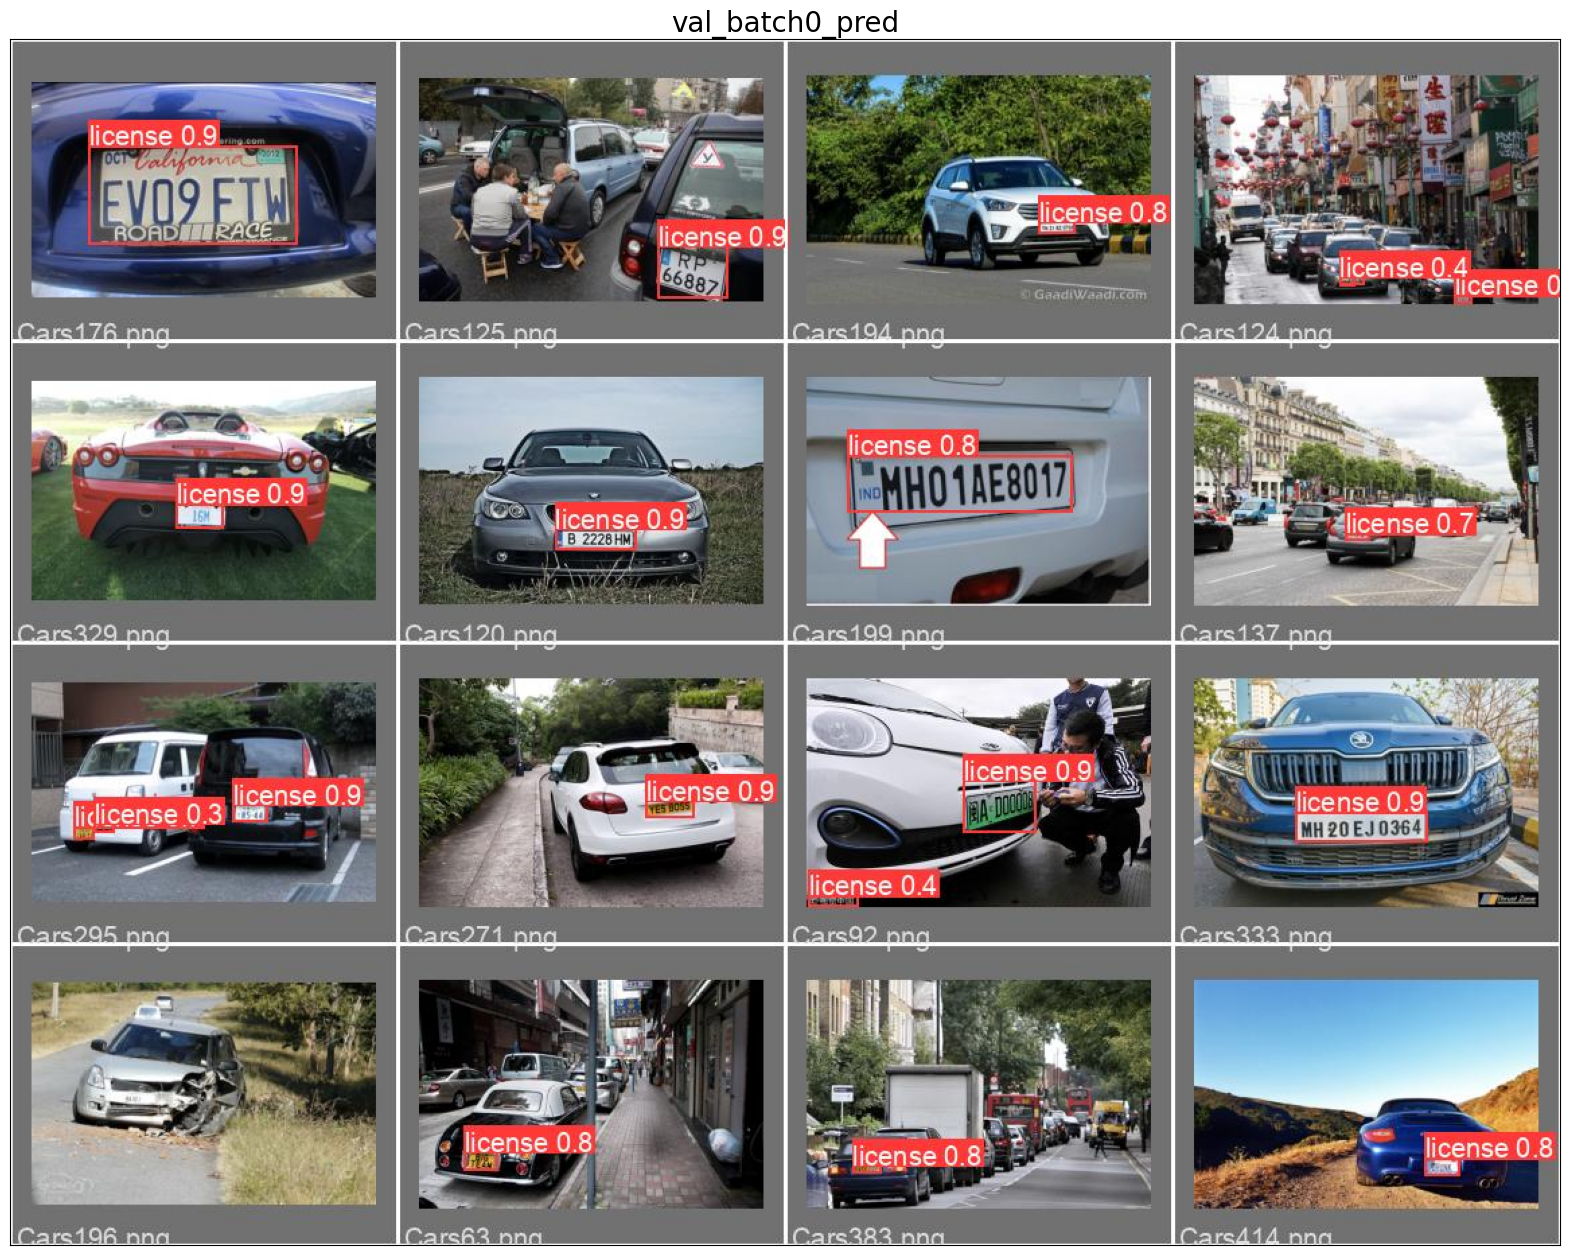

In [17]:
plt.figure(figsize=(20, 20))
imagem = mpimg.imread('/tmp/tcc_alpd/yolov5/yolov5/runs/train/exp/val_batch1_pred.jpg')
plt.imshow(imagem, extent=[0, imagem.shape[1], 0, imagem.shape[0]])
plt.title('val_batch0_pred', fontsize=20)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

In [9]:
def detect_objects(image_dir, num_images=100):
    start_time = time.time()

    model = torch.hub.load('ultralytics/yolov5', 'custom', path='runs/train/exp/weights/best.pt')

    for filename in random.sample(os.listdir(image_dir), num_images):
        if filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            
            results = model(image_path)

    end_time = time.time()
    elapsed_time = end_time - start_time
    return elapsed_time

detection_time = detect_objects(IMAGE_PATH)
print("Tempo total de detecção para 100 imagens aleatórias: {:.2f} segundos".format(detection_time))

Using cache found in /home/alertrack/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-4-11 Python-3.9.19 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12035MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Tempo total de detecção para 100 imagens aleatórias: 2.05 segundos
